In [1]:
from spatialdata_io import xenium
import spatialdata as sd
import squidpy as sq
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns

A reader for Xenium data is available in `spatialdata-io`. We used it to parse and convert to Zarr a [Xenium dataset of Human Lung Cancer](https://www.10xgenomics.com/datasets/preview-data-ffpe-human-lung-cancer-with-xenium-multimodal-cell-segmentation-1-standard).

After downloading and extracting the dataset into a directory named Xenium, we specify the path to the dataset and where we want to store our Zarr files.

In [3]:
xenium_path = "./Xenium"
zarr_path = "./Xenium.zarr"

load the data into a spatialdata object using the xenium reader.

In [4]:
sdata = xenium(xenium_path)

Convert to Zarr.

In [5]:
xenium.write(zarr_path)

From now on we only read directly from the zarr store.

In [6]:
sdata = sd.read_zarr(zarr_path)
sdata

SpatialData object with:
├── Images
│     └── 'morphology_focus': MultiscaleSpatialImage[cyx] (1, 20535, 51103), (1, 10267, 25551), (1, 5133, 12775), (1, 2566, 6387), (1, 1283, 3193)
├── Labels
│     ├── 'cell_labels': MultiscaleSpatialImage[yx] (20535, 51103), (10267, 25551), (5133, 12775), (2566, 6387), (1283, 3193)
│     └── 'nucleus_labels': MultiscaleSpatialImage[yx] (20535, 51103), (10267, 25551), (5133, 12775), (2566, 6387), (1283, 3193)
├── Points
│     └── 'transcripts': DataFrame with shape: (40257199, 11) (3D points)
├── Shapes
│     ├── 'cell_boundaries': GeoDataFrame shape: (161000, 1) (2D shapes)
│     ├── 'cell_circles': GeoDataFrame shape: (161000, 2) (2D shapes)
│     └── 'nucleus_boundaries': GeoDataFrame shape: (161000, 1) (2D shapes)
└── Tables
      └── 'table': AnnData (161000, 480)
with coordinate systems:
▸ 'global', with elements:
        morphology_focus (Images), cell_labels (Labels), nucleus_labels (Labels), transcripts (Points), cell_boundaries (Shapes), ce

For the analysis we use the `anndata.AnnData` object, which contains the count matrix, cell and gene annotations. It is stored in the `spatialdata.tables` layer.

In [7]:
sdata.tables["table"]

AnnData object with n_obs × n_vars = 161000 × 480
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'z_level', 'nucleus_count', 'cell_labels'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatialdata_attrs'
    obsm: 'spatial'

In [8]:
sdata.tables["table"].obs

,cell_id,transcript_counts,control_probe_counts,control_codeword_counts,unassigned_codeword_counts,deprecated_codeword_counts,total_counts,cell_area,nucleus_area,region,z_level,nucleus_count,cell_labels
0,aaaakjjo-1,74,0,0,0,0,74,147.254537,29.622501,cell_circles,4.0,1.0,1
1,aaaaoeme-1,55,0,0,0,0,55,118.309379,6.231563,cell_circles,5.0,1.0,2
2,aaaaofcm-1,188,0,0,0,0,188,203.609539,35.583126,cell_circles,5.0,1.0,3
3,aaabeahl-1,125,0,0,0,0,125,120.205942,21.087970,cell_circles,5.0,1.0,4
4,aaabkjgc-1,56,0,0,0,0,56,118.038442,13.230782,cell_circles,4.0,1.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
160995,oimkckeg-1,55,0,0,0,0,55,54.187502,20.591251,cell_circles,7.0,1.0,160996
160996,oimkjcem-1,134,0,0,0,0,134,104.762504,49.446096,cell_circles,7.0,1.0,160997
160997,oimklafm-1,84,0,0,0,0,84,109.187816,21.042813,cell_circles,7.0,1.0,160998
160998,oimkmnpi-1,61,0,0,0,0,61,45.923908,17.836719,cell_circles,7.0,1.0,160999


Calculate the quality control metrics on the `anndata.AnnData` using `scanpy.pp.calculate_qc_metrics`.

In [9]:
sc.pp.calculate_qc_metrics(sdata.tables["table"], percent_top=(10, 20, 50, 150), inplace=True)

The percentage of control probes and control codewords can be calculated from `sdata.tables["table"].obs`

In [10]:
cprobes = (
    sdata.tables["table"].obs["control_probe_counts"].sum() / sdata.tables["table"].obs["total_counts"].sum() * 100
)
cwords = (
    sdata.tables["table"].obs["control_codeword_counts"].sum() / sdata.tables["table"].obs["total_counts"].sum() * 100
)
print(f"Negative DNA probe count % : {cprobes}")
print(f"Negative decoding count % : {cwords}")

Negative DNA probe count % : 0.005055624161283524
Negative decoding count % : 0.0025133467754592624


Next we plot the distribution of total transcripts per cell, unique transcripts per cell, area of segmented cells and the ratio of nuclei area to their cells

<Axes: title={'center': 'Nucleus ratio'}, ylabel='Count'>

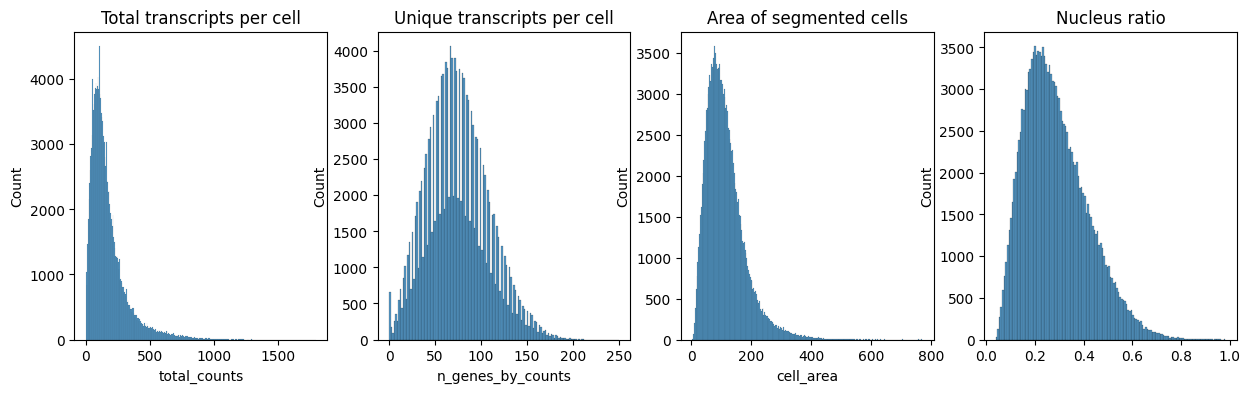

In [11]:
fig, axs = plt.subplots(1, 4, figsize=(15, 4))

axs[0].set_title("Total transcripts per cell")
sns.histplot(
    sdata.tables["table"].obs["total_counts"],
    kde=False,
    ax=axs[0],
)

axs[1].set_title("Unique transcripts per cell")
sns.histplot(
    sdata.tables["table"].obs["n_genes_by_counts"],
    kde=False,
    ax=axs[1],
)


axs[2].set_title("Area of segmented cells")
sns.histplot(
    sdata.tables["table"].obs["cell_area"],
    kde=False,
    ax=axs[2],
)

axs[3].set_title("Nucleus ratio")
sns.histplot(
    sdata.tables["table"].obs["nucleus_area"] / sdata.tables["table"].obs["cell_area"],
    kde=False,
    ax=axs[3],
)

Filter the cells based on the minimum number of counts required using `scanpy.pp.filter_cells`. Filter the genes based on the minimum number of cells required with `scanpy.pp.filter_genes`. The parameters for the both were specified based on the plots above. They were set to filter out the cells and genes with minimum counts and minimum cells respectively.

Other filter criteria might be cell area, DAPI signal or a minimum of unique transcripts.

In [12]:
sc.pp.filter_cells(sdata.tables["table"], min_counts=10)
sc.pp.filter_genes(sdata.tables["table"], min_cells=5)

Normalize counts per cell using `scanpy.pp.normalize_total`.

Logarithmize, do principal component analysis, compute a neighborhood graph of the observations using `scanpy.pp.log1p`, `scanpy.pp.pca` and `scanpy.pp.neighbors` respectively.

Use `scanpy.tl.umap` to embed the neighborhood graph of the data and cluster the cells into subgroups employing `scanpy.tl.leiden`.

In [13]:
sdata.tables["table"].layers["counts"] = sdata.tables["table"].X.copy()
sc.pp.normalize_total(sdata.tables["table"], inplace=True)
sc.pp.log1p(sdata.tables["table"])
sc.pp.pca(sdata.tables["table"])
sc.pp.neighbors(sdata.tables["table"])
sc.tl.umap(sdata.tables["table"])
sc.tl.leiden(sdata.tables["table"])

Visualize annotation on UMAP and spatial coordinates

Subplot with scatter plot in UMAP (Uniform Manifold Approximation and Projection) basis. The embedded points were colored, respectively, according to the total counts, number of genes by counts, and leiden clusters in each of the subplots. This gives us some idea of what the data looks like.

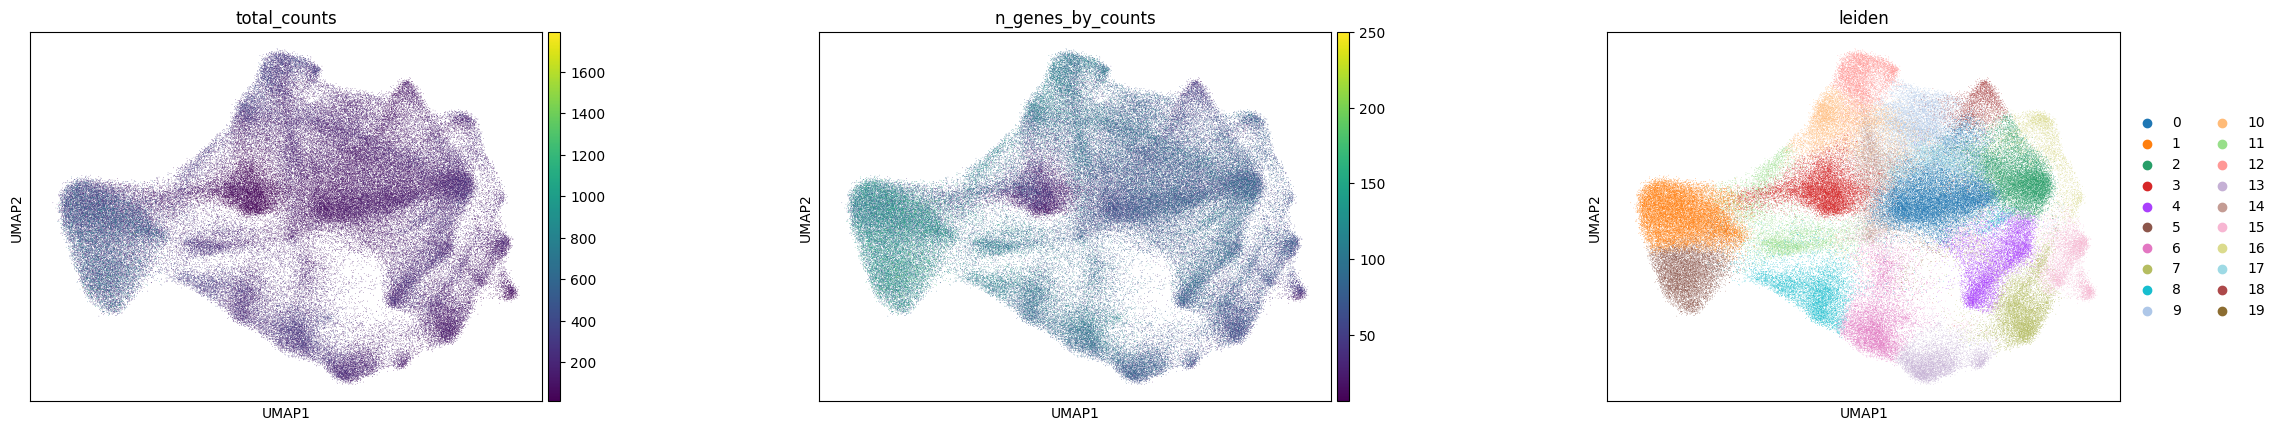

In [14]:
sc.pl.umap(
    sdata.tables["table"],
    color=[
        "total_counts",
        "n_genes_by_counts",
        "leiden",
    ],
    wspace=0.4,
)

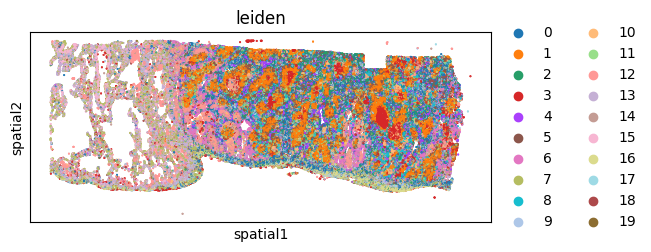

In [15]:
sq.pl.spatial_scatter(
    sdata.tables["table"],
    library_id="spatial",
    shape=None,
    color=[
        "leiden",
    ],
    wspace=0.4,
)

Computation of spatial statistics

Building the spatial neighbors graphs

This example shows how to compute centrality scores, given a spatial graph and cell type annotation.

The scores calculated are closeness centrality, degree centrality and clustering coefficient with the following properties:

- closeness centrality - measure of how close the group is to other nodes.
- clustering coefficient - measure of the degree to which nodes cluster together.
- degree centrality - fraction of non-group members connected to group members.

All scores are descriptive statistics of the spatial graph.

This dataset contains Leiden cluster groups’ annotations in `sdata.tables["table"].obs`, which are used for calculation of centrality scores.

First, we need to compute a connectivity matrix from spatial coordinates to calculate the centrality scores. We can use `squidpy.gr.spatial_neighbors` for this purpose. We use the `coord_type="generic"` based on the data and the neighbors are classified with Delaunay triangulation by specifying `delaunay=True`.

In [16]:
sq.gr.spatial_neighbors(sdata.tables["table"], coord_type="generic", delaunay=True)

Compute centrality scores

Centrality scores are calculated with `squidpy.gr.centrality_scores`, with the Leiden groups as clusters.

In [17]:
sq.gr.centrality_scores(sdata.tables["table"], cluster_key="leiden")

The results were visualized by plotting the average centrality, closeness centrality, and degree centrality using `squidpy.pl.centrality_scores`.

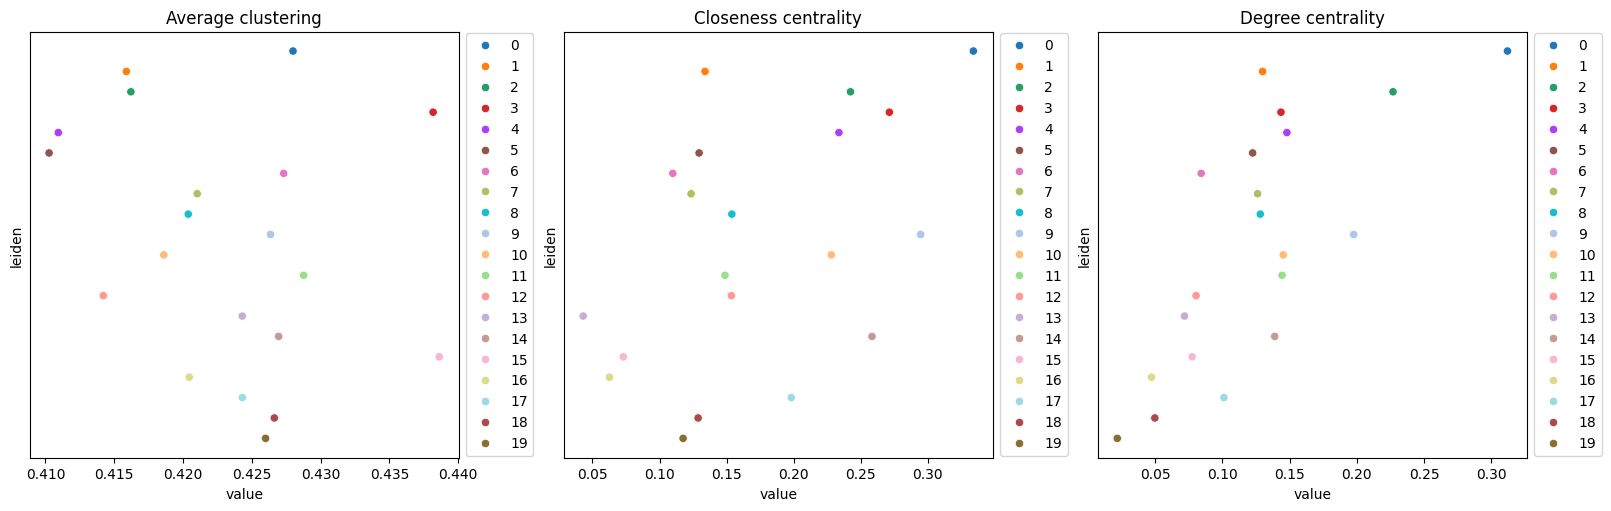

In [18]:
sq.pl.centrality_scores(sdata.tables["table"], cluster_key="leiden", figsize=(16, 5))

Compute co-occurrence probability

This example shows how to compute the co-occurrence probability.

The co-occurrence score is defined as:

$\frac{p(exp|cond)}{p(exp)}$

where $p(exp|cond)$ is the conditional probability of observing a cluster $exp$ conditioned on the presence of a cluster $cond$, whereas $p(exp)$ is the probability of observing $exp$ in the radius size of interest. The score is computed across increasing radii size around each cell in the tissue.

We can compute the co-occurrence score with `squidpy.gr.co_occurrence`. Results of co-occurrence probability ratio can be visualized with `squidpy.pl.co_occurrence`. The ‘3’ in the $\frac{p(exp|cond)}{p(exp)}$ represents a Leiden clustered group.

We can further visualize tissue organization in spatial coordinates with `squidpy.pl.spatial_scatter`, with an overlay of the expressed genes which were colored in consonance with the Leiden clusters.

First we create a new table, which is a subset of the original Anndata object, and store it in tables.

In [19]:
sdata.tables["subsample"] = sc.pp.subsample(sdata.tables["table"], fraction=0.5, copy=True)

100%|██████████| 780/780 [04:00<00:00,  3.24/s]


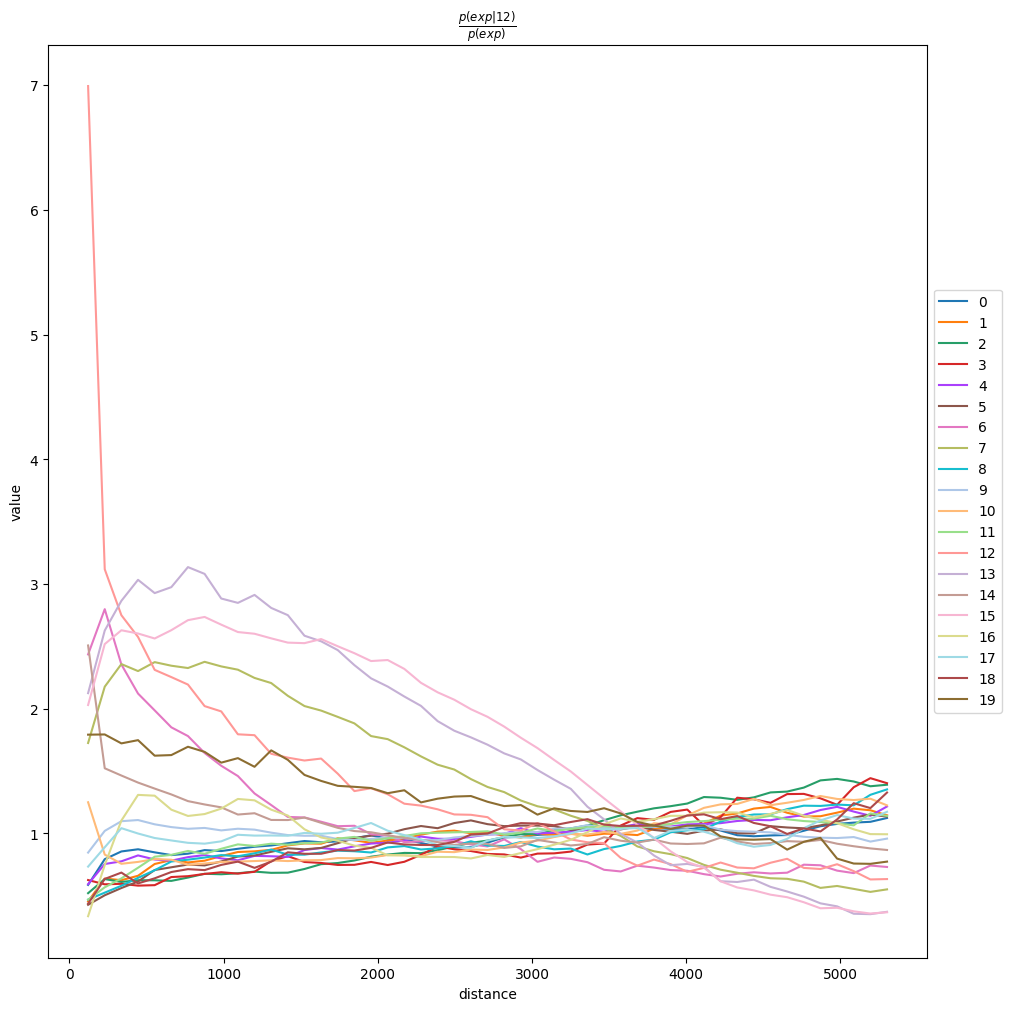

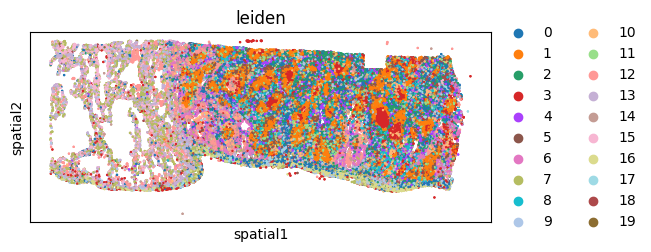

In [20]:
sq.gr.co_occurrence(
    sdata.tables["subsample"],
    cluster_key="leiden",
)
sq.pl.co_occurrence(
    sdata.tables["subsample"],
    cluster_key="leiden",
    clusters="12",
    figsize=(10, 10),
)
sq.pl.spatial_scatter(
    sdata.tables["subsample"],
    color="leiden",
    shape=None,
    size=2,
)

Neighbors enrichment analysis

This example shows how to run the neighbors enrichment analysis routine.

It calculates an enrichment score based on proximity on the connectivity graph of cell clusters. The number of observed events is compared against  permutations and a z-score is computed.

This dataset contains cell type annotations in `sdata.tables["table"].obs` which are used for calculation of the neighborhood enrichment. We calculate the neighborhood enrichment score with `squidpy.gr.nhood_enrichment`.

In [21]:
sq.gr.nhood_enrichment(sdata.tables["table"], cluster_key="leiden")

100%|██████████| 1000/1000 [00:18<00:00, 52.92/s]


And visualize the results with `squidpy.pl.nhood_enrichment`.

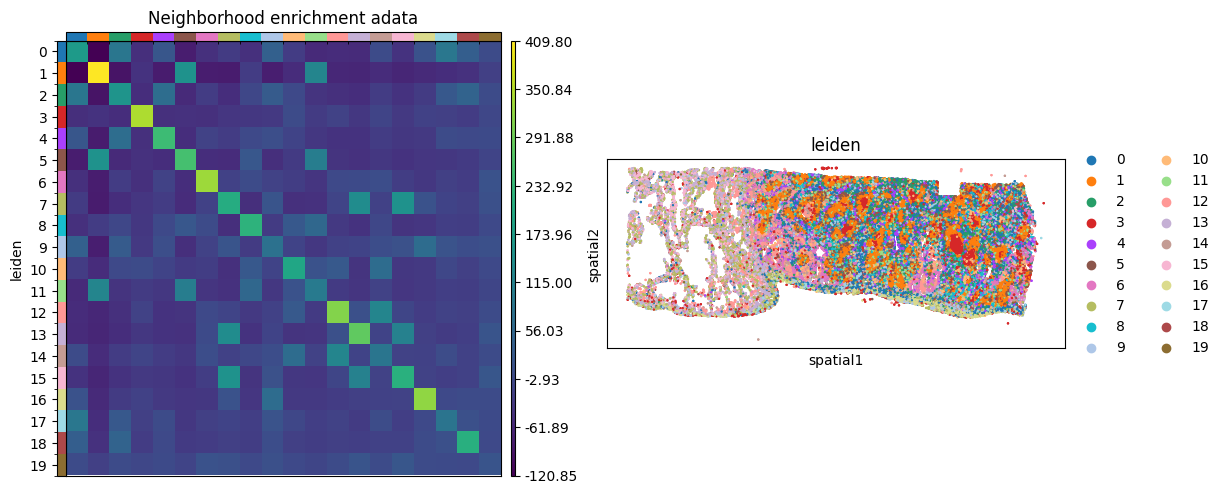

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(13, 7))
sq.pl.nhood_enrichment(
    sdata.tables["table"],
    cluster_key="leiden",
    figsize=(8, 8),
    title="Neighborhood enrichment adata",
    ax=ax[0],
)
sq.pl.spatial_scatter(sdata.tables["subsample"], color="leiden", shape=None, size=2, ax=ax[1])

Compute Moran’s I score

This example shows how to compute the Moran’s I global spatial auto-correlation statistics.

The Moran’s I global spatial auto-correlation statistics evaluates whether features (i.e. genes) shows a pattern that is clustered, dispersed or random in the tissue are under consideration.

We can compute the Moran’s I score with `squidpy.gr.spatial_autocorr` and mode = 'moran'. We first need to compute a spatial graph with `squidpy.gr.spatial_neighbors`. We will also subset the number of genes to evaluate.

In [23]:
sq.gr.spatial_neighbors(sdata.tables["subsample"], coord_type="generic", delaunay=True)
sq.gr.spatial_autocorr(
    sdata.tables["subsample"],
    mode="moran",
    n_perms=100,
    n_jobs=1,
)
sdata.tables["subsample"].uns["moranI"].head(10)

100%|██████████| 100/100 [02:17<00:00,  1.38s/]


,I,pval_norm,var_norm,pval_z_sim,pval_sim,var_sim,pval_norm_fdr_bh,pval_z_sim_fdr_bh,pval_sim_fdr_bh
AREG,0.695981,0.0,0.000004,0.0,0.009901,0.000009,0.0,0.0,0.010005
MET,0.683335,0.0,0.000004,0.0,0.009901,0.000010,0.0,0.0,0.010005
ANXA1,0.666874,0.0,0.000004,0.0,0.009901,0.000009,0.0,0.0,0.010005
EPCAM,0.633024,0.0,0.000004,0.0,0.009901,0.000011,0.0,0.0,0.010005
DMBT1,0.587696,0.0,0.000004,0.0,0.009901,0.000007,0.0,0.0,0.010005
IGKC,0.549282,0.0,0.000004,0.0,0.009901,0.000007,0.0,0.0,0.010005
IGHG1,0.518234,0.0,0.000004,0.0,0.009901,0.000007,0.0,0.0,0.010005
IDO1,0.496409,0.0,0.000004,0.0,0.009901,0.000005,0.0,0.0,0.010005
SPARC,0.445792,0.0,0.000004,0.0,0.009901,0.000007,0.0,0.0,0.010005
APOE,0.437499,0.0,0.000004,0.0,0.009901,0.000006,0.0,0.0,0.010005


We can visualize some of those genes with `squidpy.pl.spatial_scatter`. We could also pass `mode = 'geary'` to compute a closely related auto-correlation statistic, Geary’s C. See `squidpy.gr.spatial_autocorr` for more information.

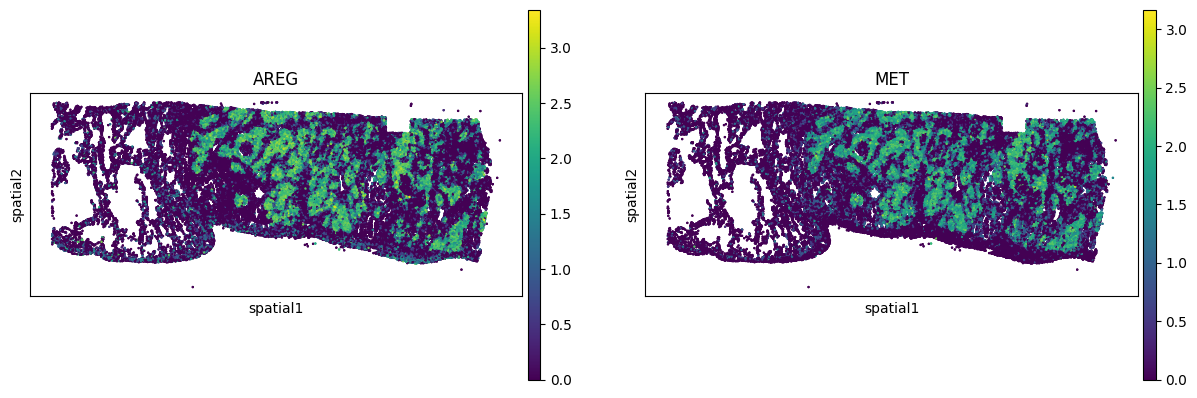

In [24]:
sq.pl.spatial_scatter(
    sdata.tables["subsample"],
    library_id="spatial",
    color=[
        "AREG",
        "MET",
    ],
    shape=None,
    size=2,
    img=False,
)

For a detailed view on how `spatialdata` can be used to analyze Xenium data, please refer to the corresponding [SpatialData tutorial](https://spatialdata.scverse.org/en/latest/tutorials/notebooks/notebooks/examples/technology_xenium.html).